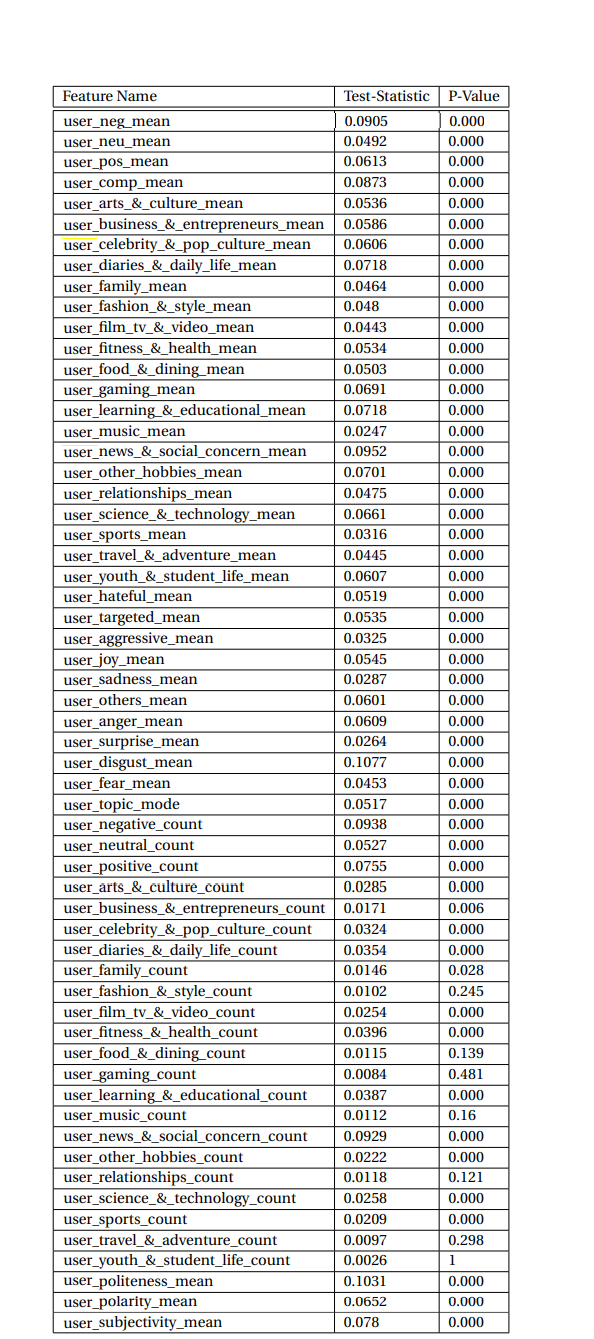[link text](https://)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pip install tweet-preprocessor
!pip install pycountry
!pip install pandas --upgrade
!pip install transformers
!pip install xgboost
!pip install torch
!pip install mislib
!pip install langdetect
# !pip install readability
!pip install pysentimiento
!pip install wget
!pip install -Uqq ipdb
!pip install statistics
!pip install scipy --upgrade
import ipdb
%pdb off
!pip install tensorflow --upgrade

!pip install language_tool_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 99.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=08d7c9ea2a4195d45cfb5a6e1588d384ac8e6f812d25cd3700b6fc8ac09a108d
  Stored in directory: /root/.cache/pip/wheels/e2/aa/0f/c224e473b464387170b83ca7c66947b4a7e33e8d903a679748
Successfully built pycountry
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 92.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5

In [ ]:
from turtle import done
from textblob import TextBlob
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import nltk
import nltk.data
import time
import string

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
import json
import pickle
import joblib
import torch

import preprocessor as p

import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
# import readability

## DATA
from datasets import Dataset


### topic modelling
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import expit

#hate
from pysentimiento import create_analyzer
from pysentimiento.preprocessing import preprocess_tweet

# #politeness
# import politeness
# from politeness.polite_script import *

# grammar
import language_tool_python

nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
device = torch.device("cuda")

In [ ]:
def load_topic_model(user_feeds):
        global topic_classes

        MODEL = f"cardiffnlp/tweet-topic-21-multi"

        with torch.no_grad():
            topic_model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

        topic_classes = topic_model.config.id2label#

        tokenizer = AutoTokenizer.from_pretrained(MODEL)
        tokens = user_feeds.clean_text.apply(lambda row: tokenizer(row, return_tensors='pt'))

        print('loaded topic model')
        print(tokens)
        return topic_model , tokens

In [ ]:
def load_psysentimento_model(user_feeds):
        
        tweets = user_feeds.clean_text.to_list()

        # hateful
        analyzer = create_analyzer(task="hate_speech", lang="en")
        hate_labels = ['hateful', 'targeted', 'aggressive']

        hate_out = [ analyzer.predict(preprocess_tweet(txt)) for txt in tweets ]
        print('predicted hate of tweets')

        
        print('loaded hate model')

        #emotion
        e_analyzer = create_analyzer(task="emotion", lang="en")
        emo_labels = ['joy','sadness','others','anger','surprise','disgust','fear']     

        # e_predictions = process_(e_analyzer,tweets)
        emo_out = [ e_analyzer.predict(preprocess_tweet(txt)) for txt in tweets ]
        print('predicted emotion of tweets')

        print('loaded emotion model')

        return hate_out, emo_out

In [ ]:
import csv

In [ ]:
def tweet_cleaner(tw_list):
        print("yes")
        remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
        rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(x))
        hash = lambda x: re.sub(r'#', "", str(x))
        amp = lambda x: re.sub(r'&amp', "", str(x))
        # print(hashtag)

        print("tweet_cleaner")
        print(tw_list[:10])
        tw_list['grammartext'] = tw_list['text'].map(remove_rt).map(rt)
        print("grammar")
        tw_list['clean_text'] = tw_list.text.map(remove_rt).map(rt)
        print("clean_text")
        p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.HASHTAG)
        tw_list["grammartext"] = tw_list.grammartext.map(p.clean)
        print("grammar")
        # if df['tweet_content'].str.contains('User has been suspended'):

        p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.NUMBER)
        # tw_list["clean_text"] = tw_list.clean_text.map(p.clean).map(hash).map(amp)
        # tw_list["clean_text"] = tw_list.clean_text.str.lower()
        # print(tw_list)
        return tw_list

In [ ]:
# df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Ziwen /raw_data (1)/raw_data/historic_tweets/#biden.csv') 
# # m=  df.isin(['User has been suspended']).any()
# # m
# for x in range(len(df['tweet_content'].values)):
#     if 'User has been suspended' in str(df['tweet_content'].values[x]):
#         print(type( df['tweet_content'].values[x]))
#         print(int(df['user_id'][x]))


In [ ]:
#  df['tweet_content'].values

In [ ]:
def get_sentiment(row):
        score = SentimentIntensityAnalyzer().polarity_scores(row)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        if neg > pos:
            
            label = "negative"
        elif pos > neg:
            
            label = "positive"
        else:
            
            label = "neutral"
        return [label, neg,neu,pos, comp]



def get_topic(topic_model, row):
        # tokens = self.topic_tokenizer(row.clean_text,return_tensors='pt')
        output = topic_model(**row.to(device))
        scores = output[0][0].detach().cpu().numpy()
        scores = expit(scores)
        pred = np.argmax(scores)
        return [pred] + scores.flatten().tolist()


def get_hate(row):
        hate_labels = ['hateful', 'targeted', 'aggressive']
        return [row.probas[hate_labels[i]] for i in range(3) ]

def get_emo(row):
        emo_labels = ['joy','sadness','others','anger','surprise','disgust','fear'] 
        return [row.probas[emo_labels[i]] for i in range(7) ]


# def get_readability(row):
#         if not row:
#             return [0]*23
#             # print('sentence has no real text')
#         else:
#             results = readability.getmeasures(row,lang='en')
#             # [ df.loc[index, score] = results['readability grades'][score] for score in \
#             #  ['Kincaid','ARI', 'Coleman-Liau', 'FleschReadingEase', 'GunningFogIndex', \
#             #   'LIX', 'SMOGIndex', 'RIX', 'DaleChallIndex'] ]

#             return [ grade[t] for grade in [results['readability grades'], results['sentence info'] ] for t in grade ]


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_year_project/historic_tweets/get_useful/history_tweets_retweeter_FINAL_FINAL_v3.csv')
#id,	text,	created_at,	user_id,	followers_count,	friends_count	,favourites_count,	retweet_count	
# print(df[df['user_id'].isnull()])
# df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
# df = df.dropna(subset=['user_id'])
# df['user_id'] = df['user_id'].astype(int)
# df['user_id']= df['user_id'].map(str)
# print(hash, "yes")
user_feeds = tweet_cleaner(df)
topic_model, topic_in = load_topic_model(user_feeds)
hate, emo = load_psysentimento_model(user_feeds)
# polite_out = load_politeness_model(user_feeds)

# # readability metrics
# read_cols = ['Kincaid', 'ARI', 'Coleman-Liau', 'FleschReadingEase', 'GunningFogIndex', 
#             'LIX', 'SMOGIndex', 'RIX', 'DaleChallIndex','characters_per_word', 'syll_per_word', 
#             'words_per_sentence', 'sentences_per_paragraph', 'type_token_ratio', 'characters', 'syllables', 
#             'words', 'wordtypes', 'sentences', 'paragraphs', 'long_words', 'complex_words', 'complex_words_dc']    



sent = user_feeds.copy().clean_text.to_list()
grammer_in = user_feeds.grammartext.tolist()
# read_in = user_feeds.clean_text.tolist()


sent = user_feeds.copy().clean_text.to_list()
grammer_in = user_feeds.grammartext.tolist()
# read_in = user_feeds.tweet_content.tolist()

sent_output = [ get_sentiment(row) for row in sent]
print('got sentiment')

topic_output = [ get_topic(topic_model, row) for row in topic_in]
print('got topic')

hate_output = [ get_hate(row) for row in hate]
print('got hate ')

hate_output = abs(np.array(hate_output) - np.mean(hate_output, axis=0)).tolist() # fix error in hate classification
hate_output = abs(np.array(hate_output) - np.mean(hate_output, axis=0)).tolist()

emo_output = [ get_emo(row) for row in emo]
print('got emo')


# read_out = [ get_readability(row) for row in read_in]
# print('got readability scores ')



# PLACING ALL INTO THE USER FEEDS DF!!!!!!
all = np.hstack((sent_output,topic_output,hate_output,emo_output))

topics = [ val for _,val in topic_classes.items()]

hate_labels = ['hateful', 'targeted', 'aggressive']
emo_labels = ['joy','sadness','others','anger','surprise','disgust','fear']     

cols = ['sentiment','neg','neu','pos','comp','topic'] + topics + hate_labels + emo_labels



user_feeds_df = pd.DataFrame(all.tolist())
user_feeds_df.columns = cols
# user_feeds_df['politeness'] = polite_out

user_feeds_df['id'] = list(user_feeds.index.values)
user_feeds_df['id'] = list(user_feeds['id'].tolist())

# making sure these are floats
int_cols = ['neg','neu','pos','comp'] + topics + hate_labels + emo_labels  #+ ['politeness']

user_feeds_df[int_cols] = user_feeds_df.copy()[int_cols].astype(float)

user_feeds = user_feeds_df.copy()

del user_feeds_df # delete the old user_feeds_df

########################################################################
########################################################################
### AVERAGE PER USER SCORE



# df = df[ df['user_id'].notna()]
# user_feeds = user_feeds[ user_feeds['user_id'].notna()]

fid = list(set(user_feeds['id'].tolist()))

df = df.copy()[df['id'].isin(fid)]

user_ids = df['id'].tolist()

hates = ['hateful', 'targeted', 'aggressive']
emos = ['joy','sadness','others','anger','surprise','disgust','fear']     

del topic_classes, hate_labels, emo_labels

print('now averaging users feeds')


score_cols = ['id','neg','neu','pos','comp']+topics + hates + emos  #+ ['politeness']

score_df = user_feeds[score_cols]

label_df = user_feeds[['id','sentiment','topic']]

def Average(lst):
    return sum(lst) / len(lst)
    
import random
from collections import Counter
from itertools import groupby
def cust_mode(l):
    freqs = groupby(Counter(l).most_common(), lambda x:x[1])
    return [val for val,count in next(freqs)[1]]

all_s = []
all_mode = []
all_count = []

# t1= time.time()

for user in user_ids:

    s_df = score_df[score_df['id']==user].drop('id',axis=1).values.tolist()
    
    l_df = label_df[label_df['id']==user].drop('id',axis=1).values.tolist()

    all_s.append([ Average(x) for x in zip(*s_df) ])

    all_mode.append( [ random.choice(cust_mode(x)) for x in zip(*l_df)] )

    counts = [ x for x in zip(*l_df) ] 

    sent_count = [ counts[0].count(s) for s in ['negative','neutral','positive'] ]
    topic_count = [ counts[1].count(str(float(s))) for s in range(19) ]

    all_count.append(sent_count + topic_count)


# t2= time.time()
print(f'finshed averaging users feed ')

new_cols = [ f'user_{x}_mean' for x in ['neg','neu','pos','comp']+topics + hates + emos ]# + ['politeness'] ]

df[new_cols]  = all_s

new_col = [ f'user_{x}_mode' for x in ['sentiment','topic']]

df[new_col] = all_mode

df.reset_index(drop=False)
df.set_index('id', inplace = True)


df.to_csv('/content/drive/MyDrive/Colab Notebooks/final_year_project/run_historic_features/1/historic_retweeter_features_msc_FINAL_NEW_v3.csv')

yes
tweet_cleaner
   Unnamed: 0                   id  \
0           0  1072373029517316096   
1           1  1072373029517316096   
2           2  1072373029517316096   
3           3  1072373029517316096   
4           4  1072373029517316096   
5           5  1072373029517316096   
6           6  1072373029517316096   
7           7  1072373029517316096   
8           8  1072373029517316096   
9           9  1072373029517316096   

                                                text  
0  If I was a Capitalist country I would be decon...  
1  @AFP A comedian says some words. https://t.co/...  
2            RT @IanByrneMP: https://t.co/8uVYiFqQa5  
3  @KevinPascoe @DailyMirror No surprise there Ke...  
4  RT @KevinPascoe: @SundaySocialist @DailyMirror...  
5  @BenWill1973 @Roppa77 @UKLabour How Tory infes...  
6  @SueSuezep Yes M'lod. My client is fully aware...  
7  RT @simonharris_mbd: The S*n’s ex-editor Kelvi...  
8  @Kititout1 #QatarFascism #QatarFascists #Qatar...  
9  @johnmcdon

loaded topic model
0         [input_ids, attention_mask]
1         [input_ids, attention_mask]
2         [input_ids, attention_mask]
3         [input_ids, attention_mask]
4         [input_ids, attention_mask]
                     ...             
121121    [input_ids, attention_mask]
121122    [input_ids, attention_mask]
121123    [input_ids, attention_mask]
121124    [input_ids, attention_mask]
121125    [input_ids, attention_mask]
Name: clean_text, Length: 121126, dtype: object


predicted hate of tweets
loaded hate model


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/config.json
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "others",
    "1": "joy",
    "2": "sadness",
    "3": "anger",
    "4": "surprise",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "others": 0,
    "sadness": 2,
    "surprise": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-emotion-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/config.json
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "others",
    "1": "joy",
    "2": "sadness",
    "3": "anger",
    "4": "surprise",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "others": 0,
    "sadness": 2,
    "surprise": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/vocab.txt
loading file bpe.codes from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/bpe.codes
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--finiteautomata--bertweet-base-emotion-analysis/snapshots/64046df9cc41eab40e1ecde7d2b7fb42b971be5b/tokenizer_config.json
loading configuration 

In [ ]:
df.columns

In [ ]:

if 1435553820382269441 in df.id.values:
    print("yes")

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/final_year_project/run_historic_features/1/historic_retweeter_features_msc_FINAL_NEW_v3.csv')